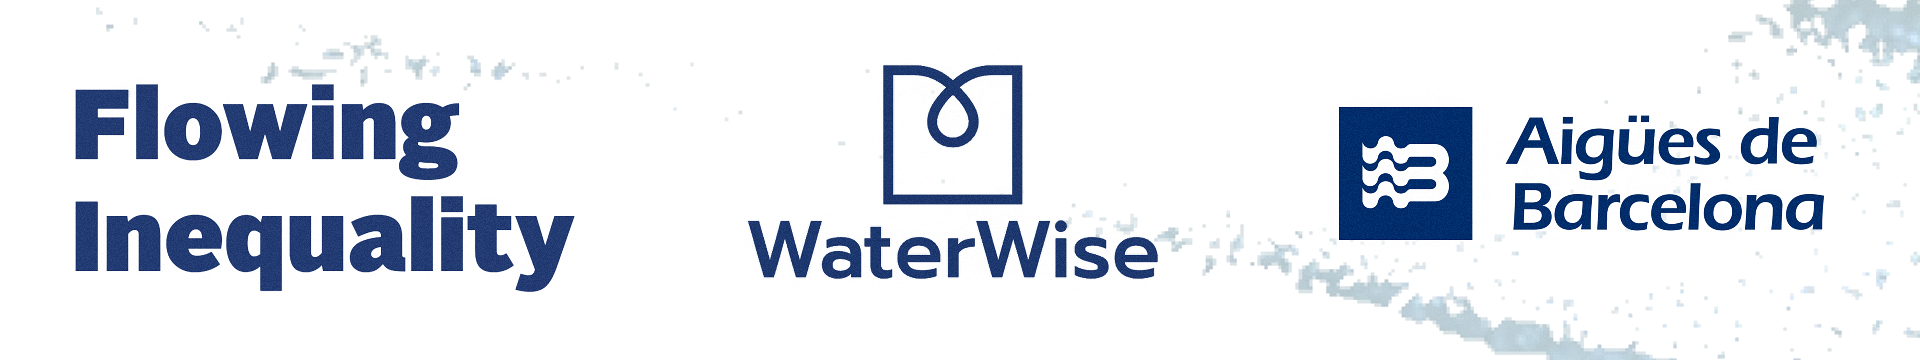


# **Flowing Inequality by WaterWise**

L'objectiu del nostre projecte és oferir a Aigües de Barcelona una eina que permeti comprendre els patrons de consum d'aigua en relació amb factors socioeconòmics mitjançant els següents mètodes:

* **Índex de desigualtat en el consum de l'aigua**: aquest indicador proporciona una visió global de les diferències de consum entre la població vulnerable i la població no vulnerable.
* **Clusterització de la població**: mitjançant dades socioeconòmiques extretes de fonts com l'INE, IDESCAT, i BCN Open Data, es clusteritzen les seccions censals per poder visualitzar els seus consums d'aigua de manera agregada i identificar patrons.
* **Classificació del consum**: es comprova si un algorisme de classificació és capaç d'identificar el nivell socioeconòmic d'una secció censal utilitzant únicament característiques dels seus patrons de consum d'aigua.

Finalment, s'ofereix una eina de visualització en forma de dashboard on es poden visualitzar els resultats dels anàlisis anteriors de manera interactiva i segmentada. Aquesta plataforma permet proporcionar una visió holística i detallada del consum d'aigua en relació amb els factors socioeconòmics analitzats.



---


# ***Importació de dades i llibreries***

A continuació, s'importen els datasets utilitzats a l'anàlisi, s'importen les llibreries necessàries, i es defineixen algunes variables globals.

Els datasets que s'importen en aquesta secció han estat netejats prèviament. Per consultar la traçabilitat de la neteja, hi ha un notebook per cada dataset  a la carpeta `cleaning` amb els detalls de les fonts consultades per obtenir-lo.

In [4]:
# EXECUTAR AQUESTA CEL·LA NOMÉS SI S'EXECUTA EL CODI A GOOGLE COLAB !!!
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
# CANVIEU EL VALOR DE ROOT PEL DIRECTORI DEL PROJECTE O PER A UNA STRING BUIDA "" PER UTILITZAR PATHS RELATIUS EN LOCAL!!!
ROOT = ""

RAW_DATA_PATH = ROOT + "cleaning/raw_data/"
CLEAN_DATA_PATH = ROOT + "cleaning/clean_data/"
OUTPUT_PATH = ROOT + "dashboard/data_for_dashboard/"

FULL_MAP_FILE = "full_map.csv"
AB_DATASET_FILE = "outlierfree_dataset_v1.csv"
IST_FILE = "ist_sc_clean.csv"
INDICADORS_IST_FILE = "indicadors_ist.csv"
RENTA_MEDIA_INE_FILE = "renta_media_ine_clean.csv"
EDAT_MITJANA_HABITATGES_FILE = "edat_mitjana_clean.csv"
CALENDARI_FILE = "calendari.csv"

*Executar les següents dos cel·les per evitar problemes amb les llibreries.*


In [6]:
%%writefile requirements.txt
numpy==1.23.5
matplotlib==3.7.1
pandas==1.5.3
geopandas==0.13.2
seaborn==0.12.2
scikit-learn==1.2.2
xgboost==2.0.2
shap==0.43.0

Overwriting requirements.txt


In [7]:
!pip install -r requirements.txt


[notice] A new release of pip available: 22.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier
import shap

In [9]:
full_map = pd.read_csv(CLEAN_DATA_PATH+FULL_MAP_FILE, dtype={"CUSEC":str, "CUMUN":str, "CSEC":str, "CDIS":str, "CMUN":str, "CUDIS":str, "CUBAR":str, "CBAR":str})
full_map["geometry"] = gpd.GeoSeries.from_wkt(full_map["geometry"])
full_map = gpd.GeoDataFrame(full_map, geometry="geometry", crs='epsg:4326')

In [10]:
data_types_ab = {"CUSEC":str,
             "district":str,
             "postcode":str}
ab_dataset = pd.read_csv(CLEAN_DATA_PATH + AB_DATASET_FILE, dtype=data_types_ab)

ab_dataset['date'] = pd.to_datetime(ab_dataset['date'])
ab_dataset['any'] = ab_dataset['date'].dt.year
ab_dataset = ab_dataset.drop(columns=["district", "postcode", "municipality", "use", "num_comptadors", "consumption_L_day"])

In [11]:
data_types_ist = {"any":int,
                  "CUSEC":str}
ist_dataset = pd.read_csv(CLEAN_DATA_PATH + IST_FILE, dtype=data_types_ist,sep=",")

In [12]:
data_types_indicadors_ist = {"CUSEC":str,
                              "any":int}

indicadors_ist = pd.read_csv(CLEAN_DATA_PATH + INDICADORS_IST_FILE, dtype=data_types_indicadors_ist)

In [13]:
rentaMedia_INE = pd.read_csv(CLEAN_DATA_PATH + RENTA_MEDIA_INE_FILE, dtype={"CUSEC":str})

In [14]:
edat_mitjana = pd.read_csv(CLEAN_DATA_PATH + EDAT_MITJANA_HABITATGES_FILE, dtype={"CUSEC":str})

In [15]:
calendar = pd.read_csv(CLEAN_DATA_PATH + CALENDARI_FILE)
calendar = calendar.rename(columns={"Fecha_Completa": "date"})
calendar["date"] = pd.to_datetime(calendar["date"])



---


# **1. Índex de desigualtat en el consum de l'aigua**

En aquesta secció, es realitza el càlcul d'un índex que mostra la diferència en el consum d'aigua entre seccions censals amb un Índex Socioeconòmic Territorial (IST) alt i baix.

L'Índex Socioeconòmic Territorial (IST) és un índex dissenyat per la Generalitat de Catalunya que agrega diferents indicadors socioeconòmics per a cada secció censal. Podeu trobar informació detallada sobre les mètriques emprades per a calcular aquest índex seguint aquest enllaç: https://www.idescat.cat/pub/?id=ist

La diferència en el consum de l'aigua entre dues seccions censals $a$ i $b$ el dia $t$ es calcula mitjançant la següent fórmula:

$$d_{\text{consum}}(a,b,t)=|{\bf w}_{a}(t)-{\bf w}_{b}(t)|$$

On ${\bf w}_{a}(t)$ és el consum d'aigua de la secció censal $a$ el dia $t$.

D'altra banda, la diferència socioeconòmica entre dues seccions censals es calcula de la següent manera:

$$d_{\text{socioeco}}(a,b)=|\text{IST}_{a}-\text{IST}_{b}|$$

Per tant, per cada parella de seccions censals, la desigualtat es calcula com::

$$d(a,b)=d_{\text{consum}}(a,b)·d_{\text{socioeco}}(a, b)$$

Per raons de complexitat computacional, s'han calculat aquestes diferències només entre el 10% de les seccions censals amb IST més alt i el 10% més baix.

Finalment, s'agreguen totes aquestes mesures mensualment utilitzant la mediana. L'ús de la mediana permet obtenir resultats més estables per la seva resistència als *outliers*.


In [16]:
# Funcions per filtrar el "top" i el "bottom" 10% per valor
def filter_top_10(group):
    top_10_percent = group['valor'] >= group['valor'].quantile(0.9)
    return group[top_10_percent]

def filter_bottom_10(group):
    bottom_10_percent = group['valor'] <= group['valor'].quantile(0.1)
    return group[bottom_10_percent]

# Apliquem la funció a cada grup (agrupat per any) pel "top" i el "bottom" 10% de les seccions censals per IST
high_ist_sample = ist_dataset.groupby('any').apply(filter_top_10).reset_index(drop=True).rename(columns={"valor":"ist"})
low_ist_sample = ist_dataset.groupby('any').apply(filter_bottom_10).reset_index(drop=True).rename(columns={"valor":"ist"})

Es calcula la diferència d'IST de cada secció censal respecte a la resta que pertany al 10% superior o al 10% inferior.

In [17]:
high_ist_sample['key'] = 1
low_ist_sample['key'] = 1

# Producte cartesià
ist_extremes = pd.merge(low_ist_sample, high_ist_sample, on=['key', 'any']).drop('key', axis=1)

# Càlcul de les diferències
ist_extremes['ist_dif'] = abs(ist_extremes["ist_x"] - ist_extremes["ist_y"])
ist_extremes = ist_extremes.drop(columns=["ist_x", "ist_y"])

Es crea el conjunt de dades amb la diferència de consum d'aigua entre les seccions censals del 10% superior/inferior d'IST.

In [18]:
low_dataset = ab_dataset.merge(low_ist_sample[["CUSEC", "any"]], on=["CUSEC", "any"], how="inner")
high_dataset = ab_dataset.merge(high_ist_sample[["CUSEC", "any"]], on=["CUSEC", "any"], how="inner")
low_dataset['key'] = 1
high_dataset['key'] = 1

extremes_consumption = pd.merge(low_dataset, high_dataset, on=['key', 'date']).drop('key', axis=1)
extremes_consumption['consumption_dif'] = (extremes_consumption["consumption_per_house_x"] - extremes_consumption["consumption_per_house_y"])**2
extremes_consumption = extremes_consumption.drop(columns=["consumption_per_house_x", "consumption_per_house_y", "any_y"]).rename(columns={"any_x":"any"})

Es crea l'índex de desigualtat multiplicant, per a cada parell de seccions censals, la diferència entre el seu consum d'aigua i la diferència en el seu índex socioeconòmic. Finalment es fa la mediana mensual.

In [19]:
daily_results = extremes_consumption.merge(ist_extremes, on=["CUSEC_x", "CUSEC_y", "any"],how="left")
daily_results["total_dif"] = np.sqrt(daily_results["consumption_dif"])*daily_results["ist_dif"]
daily_results["month"] = daily_results["date"].dt.month
index = daily_results.groupby([daily_results["date"].dt.year.rename('year'), daily_results["date"].dt.month.rename('month')])["total_dif"].median()

index = pd.DataFrame(index)
index = index.reset_index()
index['date'] = pd.to_datetime(index[['year', 'month']].assign(day=1))
index["total_dif"] = index["total_dif"]/50
index.set_index('date', inplace=True)

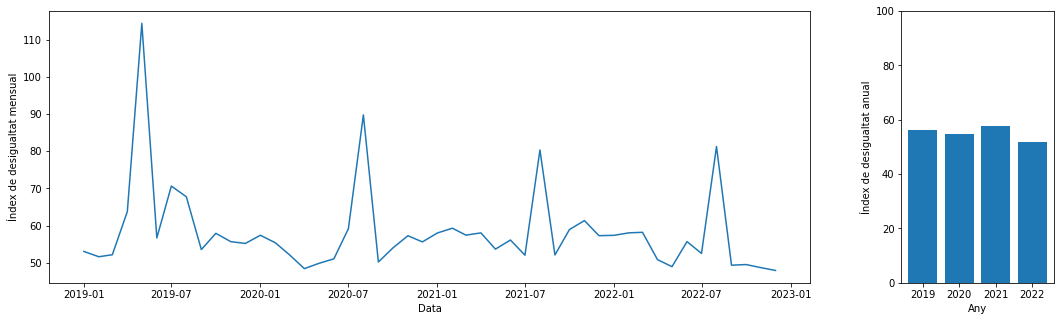

In [20]:
# Visualització de l'índex de desigualtat(mensual i anual)

fig, axs = plt.subplots(1, 2,figsize=(18, 5), gridspec_kw={'width_ratios': [5, 1]})
axs[0].plot(index["total_dif"])
axs[1].bar(index["year"].unique(), index.groupby("year")["total_dif"].median())
axs[1].set_ylim((0,100))
axs[0].set_xlabel("Data")
axs[0].set_ylabel("Índex de desigualtat mensual")
axs[1].set_xlabel("Any")
axs[1].set_ylabel("Índex de desigualtat anual")
plt.show()

El gràfic de l'esquerra mostra el valor de l'Índex de desigualtat mensual, i el de la dreta mostra el valor anual.

### **Conclusions**

Els pics corresponen a un increment en la desigualtat en el consum d'aigua entre ciutadans vulnerables i no vulnerables. En particular, els pics mensuals corresponen als mesos d'agost. Mitjançant les eines de visualització que s'ofereixen, es podrà aprofundir en el motiu d'aquests pics.

Aquesta eina es pot utilitzar per:

* Tenir una referència anual del nivell de desigualtat en el consum d'aigua.
* Monitorar la desigualtat mensual per tal de trobar anomalies de consum relacionades amb l'actualitat socioeconòmica.

Aquest índex proporciona una visió general, i utilitzant les funcionalitats de clustering i del classificador, es pot aprofundir en els fenòmens o anomalies descoberts. Això permet una comprensió més detallada dels patrons i comportaments subjacents en relació amb la desigualtat en el consum d'aigua.

In [21]:
# Exportem els valors de l'índex mensual per poder visualitzar-los al dashboard de Power BI
index.to_csv(OUTPUT_PATH+"inequality_index.csv")


---


# **2. Clustering de la població**

Partint de la hipòtesi que *hi ha diferències entre els patrons de consum d'aigua de poblacions vulnerables i no vulnerables*, s'agrupen les seccions censals en funció de factors socioeconòmics.

D'aquesta manera, si es realitza una visualització del consum de l'aigua agregat per clúster, es pretén visualitzar i comprendre si existeixen diferències significatives en els patrons de consum d'aigua entre grups socioeconòmics diferents.

In [22]:
# Ajuntem els DataFrames per 'CUSEC' (codi de la secció censal)
merged_data = pd.merge(edat_mitjana[['CUSEC', 'any']], edat_mitjana[['CUSEC', 'Edat_mitjana']], on='CUSEC')
merged_data = pd.merge(merged_data, rentaMedia_INE[['CUSEC', 'Periodo', 'Renta neta media por persona']], on='CUSEC')
merged_data = pd.merge(merged_data, full_map[['CUSEC', 'AB_Region']], on='CUSEC')
merged_data = pd.merge(merged_data, indicadors_ist[['CUSEC', 'any', 'estrangers de països de renda baixa o mitjana',
                                                     'població amb estudis baixos', 'població jove sense estudis postobligatoris',
                                                     'població ocupada', 'renda mitjana per persona', 'treballadors de baixa qualificació']], on='CUSEC')
# Filtrem files per on 'AB_Region' és True
filtered_data = merged_data[merged_data['AB_Region']]

# Agrupem per 'CUSEC'
grouped_data = filtered_data.groupby('CUSEC').agg({
    'Edat_mitjana': 'mean',
    'Renta neta media por persona': 'mean',
    'renda mitjana per persona': 'mean',
    'estrangers de països de renda baixa o mitjana': 'mean',
    'població amb estudis baixos': 'mean',
    'població jove sense estudis postobligatoris': 'mean',
    'població ocupada': 'mean',
    'treballadors de baixa qualificació': 'mean'
})

grouped_data = grouped_data.reset_index()

# 'grouped_data' conté la informació agregada per 'CUSEC' i filtrada per 'AB_Region'
grouped_data.head(3)

,CUSEC,Edat_mitjana,Renta neta media por persona,renda mitjana per persona,estrangers de països de renda baixa o mitjana,població amb estudis baixos,població jove sense estudis postobligatoris,població ocupada,treballadors de baixa qualificació
0,0801901001,97.22,10527.875,9040.0,39.216667,17.433333,32.7,53.816667,15.65
1,0801901002,106.78,8314.875,9040.0,39.216667,17.433333,32.7,53.816667,15.65
2,0801901003,106.30,8468.500,9040.0,39.216667,17.433333,32.7,53.816667,15.65


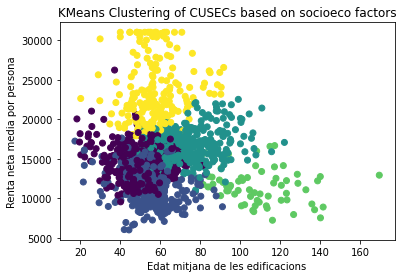

In [23]:
# Seleccionem les features que utilitzarem per fer els clústers
features_for_clustering = ['Edat_mitjana', 'Renta neta media por persona',
                            'estrangers de països de renda baixa o mitjana', 'població amb estudis baixos',
                            'població jove sense estudis postobligatoris', 'població ocupada',
                            'treballadors de baixa qualificació']

X = grouped_data[features_for_clustering]

# Estandardització  de les dades
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Escollim el nombre de clústers (basant-nos en l'EDA)
num_clusters = 5

# Utilitzem KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
grouped_data['cluster'] = kmeans.fit_predict(X_scaled)


# Visualització dels clústers
plt.scatter(grouped_data['Edat_mitjana'], grouped_data['Renta neta media por persona'], c=grouped_data['cluster'], cmap='viridis')
plt.title('KMeans Clustering of CUSECs based on socioeco factors')
plt.xlabel('Edat mitjana de les edificacions')
plt.ylabel('Renta neta media por persona')
plt.show()

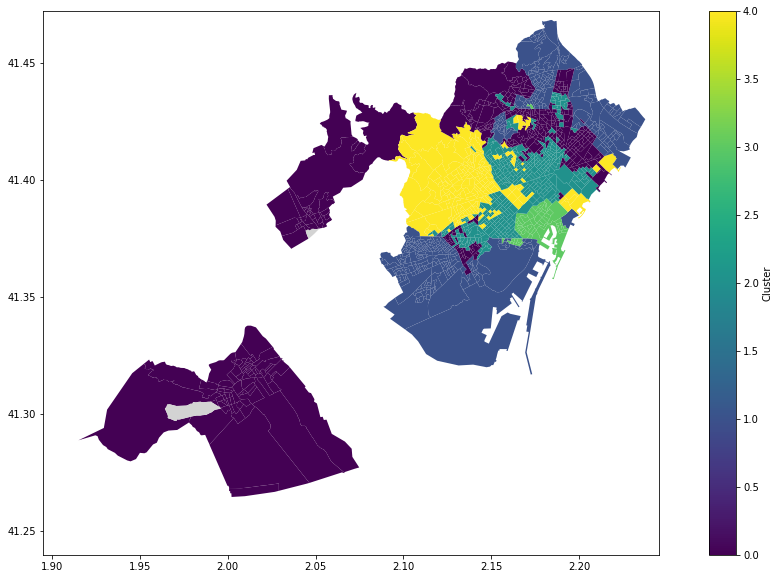

In [24]:
# Visualització dels clústers a Barcelona

result_inner = full_map.merge(grouped_data, on="CUSEC", how='left')

fig, ax = plt.subplots(1, figsize=(18,10))

result_inner.plot(column="cluster", ax=ax, alpha=1, cmap='viridis', legend=True,
                    legend_kwds={"label": "Cluster", "orientation": "vertical"},
                    missing_kwds={'color': 'lightgrey'})

ax.set_xlim(1.895, 2.245)
ax.set_ylim(41.24, 41.472)

plt.show()

### **Caracterització dels clusters**

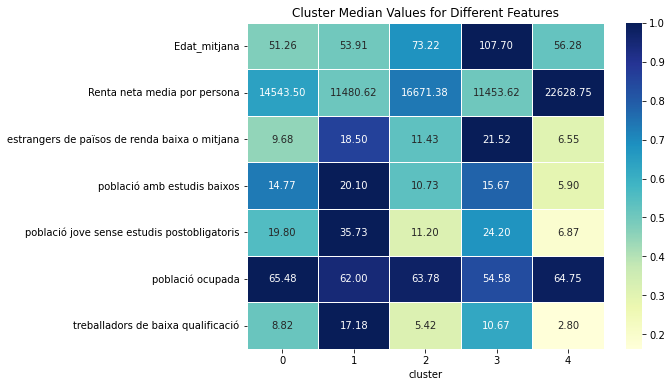

In [25]:
# Calculem la mediana de cada factor socioeconòmic de cada cluster per poder caracteritzar-los
clustering_summary = grouped_data.groupby("cluster")[features_for_clustering].median().transpose()

# Mostrem aquesta caracterització en un heatmap
plot_df = clustering_summary.div(clustering_summary.max(axis=1), axis=0)
plt.figure(figsize=(8, 6))
sns.heatmap(plot_df, annot=clustering_summary, cmap="YlGnBu", fmt=".2f", linewidths=.5)
plt.title('Cluster Median Values for Different Features')
plt.show()

Gràcies a aquesta matriu, es poden veure les característiques de cada cluster i assignar-hi un nom que els caracteritzi:

* **Cluster 0**: ingressos mitjans (14.500€/any), edificacions noves (51 anys), i nivell educatiu baix ➡ ***Ingressos mitjans i nivell educatiu baix***
* **Cluster 1**: ingressos baixos (11.400€/any) i edificacions noves (53 anys) ➡ ***Ingressos baixos i edificacions noves***
* **Cluster 2**: ingressos mitjans (16.700€/any), edificacions lleugerament antigues (73 anys), i nivell educatiu alt. ➡ ***Ingressos mitjans i nivell educatiu alt***
* **Cluster 3**: ingressos baixos (11.400€/any) i edificacions molt antigues (107 anys) ➡ ***Ingressos baixos i edificacions molt antigues***
* **Cluster 4**: ingressos molt alts (23.600€/any), edificacions noves (56 anys), nivell educatiu alt. ➡ ***Ingressos molt alts***

A continuació compararem el consum d'aigua del cluster *Ingressos molt alts* amb el d'*ingressos baixos i edificacions molt antigues* durant el 2022.

In [26]:
consum_cluster = pd.merge(ab_dataset, grouped_data[["CUSEC", "cluster"]], on=["CUSEC"], how="inner")
consum_cluster = consum_cluster.groupby(["date", "cluster"], as_index=False)["consumption_per_house"].median()

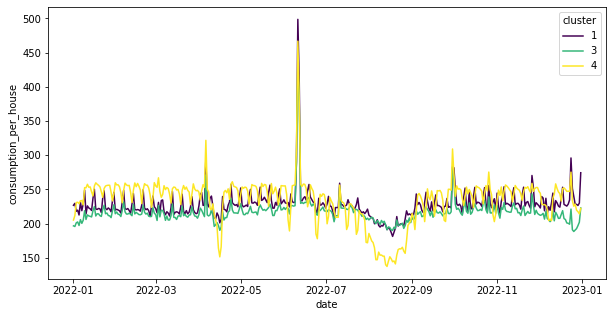

In [27]:
plt.figure(figsize=(10, 5))

cluster_palette = sns.color_palette("plasma", len(result_inner["cluster"].unique()))

sns.lineplot(data=consum_cluster[(consum_cluster["date"].dt.year==2022) & (consum_cluster["cluster"].isin([1, 3, 4]))], x="date", y="consumption_per_house", hue="cluster", palette='viridis')
plt.show()

### **Conclusions**

Les conclusions obtingudes a través del clustering proporcionen una visió detallada dels diferents patrons de consum d'aigua entre els clústers socioeconòmics.

Com es pot observar, hi ha dues temporades molt marcades pel que fa a la relació entre els patrons de consum dels diferents clústers:

* Durant tot l'any, el clúster d'ingressos molt alts mostra un consum mitjà al voltant de 30L més per comptador que la resta de clústers. A més, el seu consum augmenta durant els dies laborables i disminueix els caps de setmana, mentre que als clústers d'ingressos baixos mostren un comportament invers, baixant durant els dies laborables i pujant el cap de setmana.

* Durant les vacances d'agost, o durant festius i ponts, els ciutadans dels clústers d'ingressos alts i mitjos marxen de vacances baixant el seu consum, mentre que els d'ingressos baixos no mostren una baixada significativa respecte al seu consum habitual.

Aquestes observacions es poden correlacionar amb els resultats de l'índex de desigualtat en el consum d'aigua, especialment durant el mes d'agost. Així, es pot concloure que aquests comportaments tenen una influència directa en la desigualtat en el consum d'aigua, com es demostra mitjançant l'índex proposat a la part 1. Aquesta informació és crucial per a la comprensió dels factors que afecten la distribució desigual del consum d'aigua i el valor del nostre índex.

In [28]:
# Exportem les relacions seccio_censal-cluster per tal de poder-les utilitzar al Power BI
cusec_cluster_data = grouped_data[['CUSEC', 'cluster']]
cusec_cluster_data.to_csv(OUTPUT_PATH + 'cusec_cluster_data.csv', index=False)



---


# **3. Classificador de sèries temporals**

L'objectiu del classificador és determinar si, amb només les característiques del consum d'aigua de les diferents seccions censals, un model de Machine Learning de classificació pot identificar si la secció censal té un Índex Socioeconòmic Territorial (IST) alt o baix.

Així doncs, es busca verificar si el classificador té la capacitat de reconèixer i identificar patrons de consum que estiguin relacionats amb el nivell socioeconòmic de la població, o no.

In [29]:
# Carregant les dades
ab_dataset_calendar = pd.merge(ab_dataset, calendar, on='date', how='inner')

El classificador rebrà mètriques sobre el consum d'aigua agrupades per mes, any, i CUSEC (codi de la secció censal) com a input. En aquest sentit, l'objectiu és que el classificador sigui capaç d'identificar els diferents patrons de consum.

In [30]:
# Consum mitjà
consumo_CUSEC_mean_mes = ab_dataset_calendar.groupby(['CUSEC', 'Mes', 'any'])['consumption_per_house'].mean().reset_index()
consumo_CUSEC_mean_mes.rename(columns={'consumption_per_house': 'mean_consumption_month'}, inplace=True)

# Desviació estàndard
consumo_CUSEC_std_mes = ab_dataset_calendar.groupby(['CUSEC', 'Mes', 'any'])['consumption_per_house'].std().reset_index()
consumo_CUSEC_std_mes.rename(columns={'consumption_per_house': 'std_consumption_month'}, inplace=True)

# A causa de la neteja d'outliers, si no hi han suficients dades per un mes, s'utilitzen les del mes anterior, o en cas que també faltin, les del mes següent.
consumo_CUSEC_std_mes['std_consumption_month'] = consumo_CUSEC_std_mes.groupby('CUSEC')['std_consumption_month'].transform(lambda x: x.fillna(x.shift()))
consumo_CUSEC_std_mes['std_consumption_month'] = consumo_CUSEC_std_mes.groupby('CUSEC')['std_consumption_month'].transform(lambda x: x.fillna(x.shift(-1)))

# Consum màxim
max_daily_consumption_mes = ab_dataset_calendar.groupby(['CUSEC', 'Mes', 'any'])['consumption_per_house'].max().reset_index()
max_daily_consumption_mes.rename(columns={'consumption_per_house': 'max_consumption_month'}, inplace=True)

# Consum mínim
min_daily_consumption_mes = ab_dataset_calendar.groupby(['CUSEC', 'Mes', 'any'])['consumption_per_house'].max().reset_index()
min_daily_consumption_mes.rename(columns={'consumption_per_house': 'min_consumption_month'}, inplace=True)

# Consum mitjà dels dies entre setmana
workday_consumption_mean = ab_dataset_calendar[ab_dataset_calendar['Es_Dia_Entre_Semana'] == 1].groupby(['CUSEC', 'Mes', 'any'])['consumption_per_house'].mean().reset_index()
workday_consumption_mean.rename(columns={'consumption_per_house': 'mean_consumption_workday_month'}, inplace=True)

# Consum mitjà del cap de setmana
weekend_consumption_mean = ab_dataset_calendar[ab_dataset_calendar['Es_Dia_Entre_Semana'] == 0].groupby(['CUSEC', 'Mes', 'any'])['consumption_per_house'].mean().reset_index()
weekend_consumption_mean.rename(columns={'consumption_per_house': 'mean_consumption_weekend_month'}, inplace=True)

# Consum mitjà dels dies festius (festius i possibles ponts)
festivo_consumption_mean = ab_dataset_calendar[ab_dataset_calendar['Es_Festivo'] == 1].groupby(['CUSEC', 'Mes', 'any'])['consumption_per_house'].mean().reset_index()
festivo_consumption_mean.rename(columns={'consumption_per_house': 'mean_consumption_festivo_month'}, inplace=True)

In [31]:
# Preparem l'input del classificador
clasificator_dataset = (
    pd.merge(consumo_CUSEC_mean_mes, consumo_CUSEC_std_mes, on=['CUSEC', 'Mes', 'any'], how='left')
    .merge(max_daily_consumption_mes, on=['CUSEC', 'Mes', 'any'], how='left')
    .merge(min_daily_consumption_mes, on=['CUSEC', 'Mes', 'any'], how='left')
    .merge(workday_consumption_mean, on=['CUSEC', 'Mes', 'any'], how='left')
    .merge(weekend_consumption_mean, on=['CUSEC', 'Mes', 'any'], how='left')
    .merge(festivo_consumption_mean, on=['CUSEC', 'Mes', 'any'], how='left')
    .merge(ist_dataset.rename(columns={"valor":"ist"}), on=['CUSEC', 'any'], how='left')
)

# A causa de la quantitat de NaNs per les features de consums entre setmana, cap de setmana i festius, netegem les dades perquè no hi hagin elements buits
clasificator_dataset.dropna(subset = ['mean_consumption_workday_month', 'mean_consumption_weekend_month', 'ist'], inplace = True)
clasificator_dataset['mean_consumption_festivo_month'].fillna(0, inplace = True)

In [32]:
# Tenint en compte l'histograma  de valors d'IST, agafem manualment un límit sobre el qual agafarem les dades per entrenar el classificador
lower_bound = 80
upper_bound = 125

# Agafem només els IST dins dels rangs que hem establert
clasificator_dataset_outside_range = clasificator_dataset[(clasificator_dataset['ist'] <= lower_bound) | (clasificator_dataset['ist'] >= upper_bound)].copy()

# Identifiquem els IST per sota de 80 com a 0 (IST baix), i 1 (IST alt). Aquesta columna serà la "target".
clasificator_dataset_outside_range['target'] = np.where(clasificator_dataset_outside_range['ist'] <= lower_bound, 0, 1)

###  Entrenament i performance del classificador

In [33]:
# Agafem les dades de les features de consum
features = clasificator_dataset_outside_range.drop(['target', 'ist', 'CUSEC', 'any'], axis=1)

# Seleccionem com a target l'IST codificat a 0 o 1 depenent de si és alt o baix
target = clasificator_dataset_outside_range['target']

# Entrenament del model
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

clf_XGB = XGBClassifier(random_state=42)
clf_XGB.fit(X_train.to_numpy(), y_train.to_numpy())
y_pred = clf_XGB.predict(X_test)

# Calculem diferents mètriques d'avaluació de la performance del classificador
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Precisió: {accuracy}")
print(f"Matriu de confusió:\n{conf_matrix}")
print(f"Report de classificació:\n{classification_rep}")

Precisió: 0.8912266772528781
Matriu de confusió:
[[1115  143]
 [ 131 1130]]
Report de classificació:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1258
           1       0.89      0.90      0.89      1261

    accuracy                           0.89      2519
   macro avg       0.89      0.89      0.89      2519
weighted avg       0.89      0.89      0.89      2519



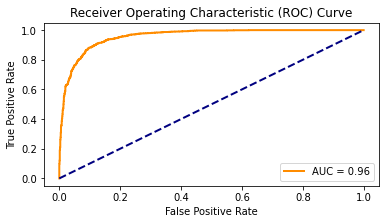

In [34]:
y_prob = clf_XGB.predict_proba(X_test)[:, 1]

# Calculem la ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculem el AUC-ROC score
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

S'observa que el classificador té una precisió considerablement alta. Això ens indica que el classificador ha après a diferenciar entre seccions censals de nivell socioeconòmic alt i baix només mirant al seu consum d'aigua, demostrant que sí que existeixen patrons de consum relacionats amb el nivell socioeconòmic.

### Prediccions

Un cop hem entrenat el classificador, l'utilitzem per trobar la probabilitat, per cada secció censal, que les seves característiques de consum corresponguin a la d'una secció censal amb IST alt.

In [35]:
# Agafem totes les dades d'abans de filtrar els IST, i fem les prediccions
inputs = clasificator_dataset.drop(['ist', 'CUSEC', 'any'], axis=1)

# Les prediccions ens tornaran una "tuple" per una banda, de la probabilitat que la secció censal li correspongui un IST alt, o un IST baix, tenint en compte les seves dades de consum
predictions = clf_XGB.predict_proba(inputs)

# En aquest cas, agafem les probabilitats de tenir un IST alt
clasificator_dataset["prob_low_ist"] = predictions[:, 1]

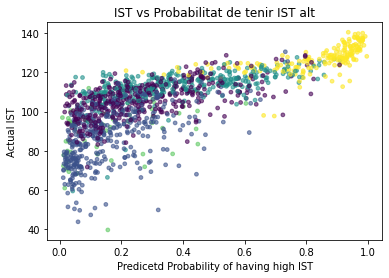

In [36]:
# Fem una viualització de les dades, agrupant per CUSEC (secció censal).

predictions_clasificator_dataset_grouped = clasificator_dataset.groupby(['CUSEC'])[['ist', 'prob_low_ist']].mean().reset_index()
predictions_clasificator_dataset_grouped = predictions_clasificator_dataset_grouped.merge(cusec_cluster_data, on="CUSEC", how="left")
plt.scatter(predictions_clasificator_dataset_grouped['prob_low_ist'], predictions_clasificator_dataset_grouped['ist'], alpha = 0.6, s=14, c=predictions_clasificator_dataset_grouped["cluster"])

plt.xlabel('Predicetd Probability of having high IST')
plt.ylabel('Actual IST')
plt.title('IST vs Probabilitat de tenir IST alt')

plt.show()

Més endavant es comenten aquests resultats en profunditat.

Abans, s'utilitza SHAP, una tècnica d'Explainable AI (Inteligencia Artificial Explicable) basada en teoria de jocs, per entendre les relacions que ha après el classificador. Això permetrà conèixer les característiques del consum més notables que permeten al classificador diferenciar entre seccions censals d'IST alt i baix.



In [37]:
explainer = shap.Explainer(clf_XGB.predict, X_test)
shap_values = explainer(X_test)

ExactExplainer explainer: 2520it [01:14, 30.65it/s]                                                                    


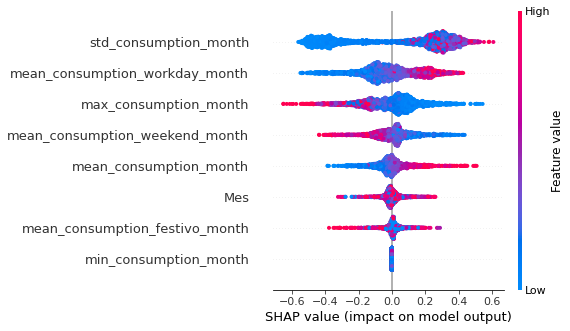

In [38]:
shap.summary_plot(shap_values, X_test)

### **Conclusions**

A partir de la visualització, es pot intuir una tendència lineal amb poc pendent.

Es pot identificar que molts dels IST estan situats al costat esquerre del gràfic. Aquesta observació, quan es relaciona amb les visualitzacions anteriors del consum per secció censal agrupades per IST, suggereix que els CUSECs amb IST alt presenten un consum mitjà notablement superior a la mitjana. A més, considerant també que el nivell mitjà-alt segueix unes tendències similars, la resta de divisions tenen uns patrons molt similars.

Aquest fenomen porta a la conclusió que els CUSEC alts tenen patrons de consum molt particulars, els quals el nostre classificador ha identificat amb precisió. Així doncs, com es mostra a la part superior dreta del gràfic, hi ha un clúster de CUSECs alts que han estat correctament classificats amb probabilitat molt alta. Això indica que el model ha après amb èxit els patrons associats a aquests nivells socioeconòmics elevats.


A partir d'aquesta visualització, se'n deriven dues conclusions principals:
- La singularitat dels consums elevats de les seccions censals amb IST alt.
- La relativa similitud dels consums de la resta de seccions censals, sense considerar les diferències vistes en les visualitzacions de consum.

Finalment, aquesta representació gràfica pot proporcionar nous "insights" valuosos. Considerant s'ha comprovat que hi ha patrons i diferències entre els consums de seccions censals amb IST alt i baix respectivament, es pot fer incís en seccions censals on el seu consum no té patrons similars als seus semblants (entenent com a semblants, CUSEC amb similar IST).

Es poden revelar casos interessants, com ara:
- Seccions censals amb IST baix, amb patrons de consums atribuïts a un IST alt.
- Seccions censals amb IST alt, amb patrons de consums atribuïts a un IST baix.

Mitjançant les eines de visualització, aquestes situacions poden ser explorades més a fons, permetent la identificació i investigació de les causes d'aquests patrons singulars de consum.

In [39]:
# Exportem el dataset amb les probabilitats per tal de poder utilitzar-les al Power BI
clasificator_dataset.to_csv(OUTPUT_PATH + "classificator_probabilities_low_ist.csv")

---

# **Consideracions finals**

Gràcies a aquest anàlisi, es demostra que existeixen patrons de consum diferents entre els segments de població vulnerables i no vulnerables.

El clustering permet veure que després d'agrupar seccions censals tenint en compte factors purament socioeconòmics, es pot veure una diferència en els seus consums; mentres que el classificador ha permés veure que només tenint en compte característiques del consum, un algorítme de machine learning es capaç de diferenciar entre seccions censals de nivell socioeconòmic alt i baix.

Altrament, presentem un índex de desigualtat que mostra de manera general l'estat de la desigualtat socioeconòmica en el consum de l'aigua, i un dashboard on visualitzar tots aquests resultats.

Finalment, considerar que l'anàlisi no és estàtic. Aquest codi es pot executar mensualment amb dades actualitzades, i el dashboard de Power BI es pot alimentar amb els outputs d'aquest notebook i amb les dades de telelectura en temps real per poder extreure insights immediats sobre la desigualtat en el consum de l'aigua.


# **Objectius futurs**

Partint dels resultats i visualitzacions del nostre projecte, s'ha de tenir en compte les diferents limitacions a l'hora d'oferir resultats exactes, i considerar el potencial de noves eines.

Seguidament, oferim un llistat de millores que considerem que podrien afegir molt valor a l'eina final:

1. **Explicació del valor de l'índex**: considerant que el valor de l'índex que apareix al dashboard és relativament explicatiu, l'objectiu seria que utilitzant només el valor de l'índex es pogués identificar la situació de desigualtat, sense necessitat de context visual en forma de gràfic.

2.  **Càlcul de l'índex**: En un inici, es va voler calcular l'índex de forma que totes les seccions censals es diferenciessin amb totes elles. A causa de la complexitat computacional de càlcul, s'ha considerat un subconjunt de seccions censals. Utilitzar totes les seccions censals pel càlcul ens portaria a afegir valor a l'indicador.

3. **Afegir un model de regressió**: Mitjançant un model de regressió, i considerant que s'ha comprovat que hi ha diferències en el consum basant-nos en factors socioeconòmics, es podria inferir en quins d'aquests factors estan més correlacionats amb els patrons de consum.

3. **Tractament d'outliers**: les nostres dades han sigut relativament netejades d'outliers. Una neteja profunda podria influir en la precisió i valor dels resultats.

4.  **Granularitat de l'anàlisi**: augmentar la granularitat de l'anàlisi clusteritzant cada client en funció de les seves característiques socioeconòmiques, en lloc de les seccions censals. També es podria augmentar la granularitat de l'anàlisi classificant el consum de cada client entre vulnerable o no vulnerable, en lloc de fer-ho per secció censal.

5.  **Granularitat temporal**: augmentar la granularitat de l'anàlisi estudiant el consum horari en lloc del consum diari, podent arribar a trobar patrons més profunds.